#### CESM-HR
- SST 2070-2100 (JJA)
- SST 1970-2000 (JJA)
- SST 2070-2100 (JJA) - SST 1970-2000 (JJA)
  The PGW deltas we are adding
 

#### SST of intermediate file format LENS2 
 
NOTE: use test env

Ming Ge Feb. 2025

In [2]:
import glob
import os
from pathlib import Path
import numpy as np
import xarray as xr
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings 
warnings.filterwarnings("ignore")

import datetime

import warnings
import dask
#import dask_jobqueue
#import distributed

from matplotlib import ticker, cm
#import pop_tools

#### Define some functions

In [3]:
# define function to get you the data you want relatively quickly 

def read_dat(files, variables, pop=False):
    # reset coords means they are reset as variables
    def preprocess(ds):
        return ds[variables].reset_coords(drop=True) 

    ds = xr.open_mfdataset(files, parallel=True, preprocess=preprocess,
                           chunks={'time':1, 'nlon': -1, 'nlat':-1},
                           combine='by_coords')
    if pop==True:
        file0 = xr.open_dataset(files[0])
        ds.update(file0[['ULONG', 'ULAT', 'TLONG', 'TLAT']])
        file0.close()

    ds
    return ds

In [4]:
# define function to be able to plot POP output properly on cartopy projections
def pop_add_cyclic(ds):
    
    nj = ds.TLAT.shape[0]
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data
    
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon)    
    lon  = np.concatenate((tlon, tlon + 360.), 1)
    lon = lon[:, xL:xR]

    if ni == 320:
        lon[367:-3, 0] = lon[367:-3, 0] + 360.        
    lon = lon - 360.
    
    lon = np.hstack((lon, lon[:, 0:1] + 360.))
    if ni == 320:
        lon[367:, -1] = lon[367:, -1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:, 0] = lon[:, 0] - 1e-8

    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
    
    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})
    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)       
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), 
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})
                
            
    return dso

#### Read Future '2070-2100' SST(JJA) of CESM-HR
10-member ensemble of CESM HR RCP85 (2006-2100) simulations.

In [7]:
%%time
dir_hr = '/glade/campaign/collections/rda/data/d651009/'
dir_o = '/glade/campaign/mmm/c3we/mingge/CESM-HR/'
flnm_o = dir_o + 'sst_JJA_2070-2100.nc'

n_mem = 10

year_fs = 2070
year_fe = 2100
year_f = str(year_fs) + '-' + str(year_fe)
print(year_f)

name_0 = 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-'
name_1 = '-2006-2100.'

period_1d = ['206601-207512', '207601-208512', '208601-209512', '209601-210012']
n_period = len(period_1d)

selected_months = [6, 7, 8]  # June, July, Aug
start_date = '2070-06-01'

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        # Add cyclic point
        ds_cyc = pop_add_cyclic(ds)
        sst_f = ds_cyc.SST_JJA
else:
    count = 0
    is_first = True
    for nm in range(n_mem):
        if nm == 0:
            member_name = name_0 + 'sehires38' + name_1 + str(nm+1).zfill(3)
        elif nm==1:
            member_name = name_0 + 'hires1.0.30' + name_1 + str(nm+1).zfill(3)
        elif nm==2:
            member_name = name_0 + 'hires1.0.31' + name_1 + str(nm+1).zfill(3)
        elif nm==4 or nm==3:
            member_name = name_0 + 'hires1.0.44' + name_1 + str(nm+1).zfill(3)
        else:
            member_name = name_0 + 'hires1.0.46' + name_1 + str(nm+1).zfill(3)

        dir_0 = dir_hr + member_name + '/ocn/proc/tseries/month_1/'

        for nn in range(n_period):
            flnm = dir_0 + member_name + \
                '.pop.h.SST.'+ period_1d[nn] + '.nc'
            #print(flnm)
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                # select data corresponding to selected_months
                sst = ds.SST.sel(time=ds.time.dt.month.isin(selected_months))\
                    .sel(time=slice(start_date, None))
            
                count = count + sst.shape[0]
                if is_first == True:
                    sst_sum = sst.sum(dim='time') 
                    is_first = False
                else:
                    sst_sum = sst_sum + sst.sum(dim='time') 
         
    sst_sum = sst_sum/float(count)
    sst_jja = sst_sum.rename('SST_JJA')
    sst_jja.to_netcdf(flnm_o)

2070-2100
/glade/campaign/mmm/c3we/mingge/CESM-HR/sst_JJA_2070-2100.nc exist
CPU times: user 254 ms, sys: 129 ms, total: 382 ms
Wall time: 586 ms


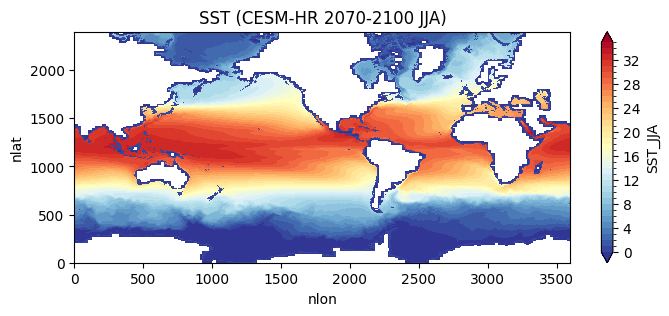

In [10]:
# Replace all -1 values with NaN
sst_f = sst_f.where(sst_f != -1)

sst_f.plot(figsize=(8, 3), 
           cmap='RdYlBu_r',  
           extend='both', 
           levels=np.arange(0, 36, 1));
plt.title('SST (CESM-HR 2070-2100 JJA)');

In [12]:
dir_hr = '/glade/campaign/collections/rda/data/d651007/'
flnm_o = dir_o + 'sst_JJA_1970-2000.nc'

year_fs = 1970
year_fe = 2000
end_date = '2000-08-31'
year_f = str(year_fs) + '-' + str(year_fe)
print(year_f)

name_0 = 'b.e13.BHISTC5.ne120_t12.cesm-ihesp-'
name_1 = '-1920-2005.'

period_1d = ['197001-197912', '198001-198912', '199001-199912', '200001-200512']
n_period = len(period_1d)

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
    with xr.open_dataset(flnm_o) as ds:
        # Add cyclic point
        ds_cyc = pop_add_cyclic(ds)
        sst_h = ds_cyc.SST_JJA
        
else:
    count = 0
    is_first = True
    for nm in range(n_mem):
        if nm == 0:
            member_name = name_0 + 'sehires38-1850-2005.001'
        elif nm==1 or nm==2:
            member_name = name_0 + 'hires1.0.30' + name_1 + str(nm+1).zfill(3)
        elif nm==3 or nm==4:
            member_name = name_0 + 'hires1.0.44' + name_1 + str(nm+1).zfill(3)
        elif nm==5:
            member_name = name_0 + 'hires1.0.45' + name_1 + str(nm+1).zfill(3)
        else:
            member_name = name_0 + 'hires1.0.46' + name_1 + str(nm+1).zfill(3)

        dir_0 = dir_hr + member_name + '/ocn/proc/tseries/month_1/'
    
        for nn in range(n_period):
            flnm = dir_0 + member_name + \
                '.pop.h.SST.'+ period_1d[nn] + '.nc'
            
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                # select data corresponding to selected_months
                sst = ds.SST.sel(time=ds.time.dt.month.isin(selected_months)) \
                            .sel(time=slice(None, end_date))
            
                count = count + sst.shape[0]
                if is_first == True:
                    sst_sum = sst.sum(dim='time') 
                    is_first = False
                else:
                    sst_sum = sst_sum + sst.sum(dim='time') 
         
    sst_sum = sst_sum/float(count)
    sst_jja = sst_sum.rename('SST_JJA')
    sst_jja.to_netcdf(flnm_o)

1970-2000
/glade/campaign/mmm/c3we/mingge/CESM-HR/sst_JJA_1970-2000.nc exist


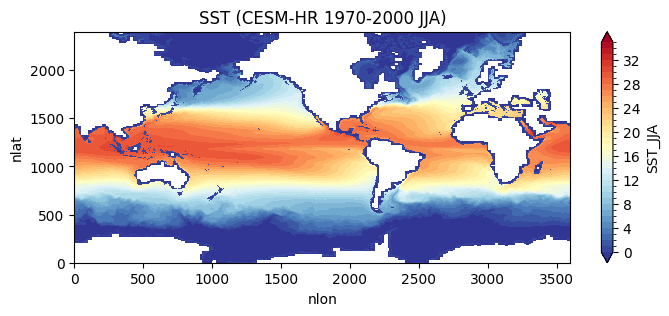

In [15]:
# Replace all -1 values with NaN
sst_h = sst_h.where(sst_h != -1)

sst_h.plot(figsize=(8, 3),
           cmap='RdYlBu_r',
           extend='both',
           levels=np.arange(0, 36, 1))

plt.title('SST (CESM-HR 1970-2000 JJA)');

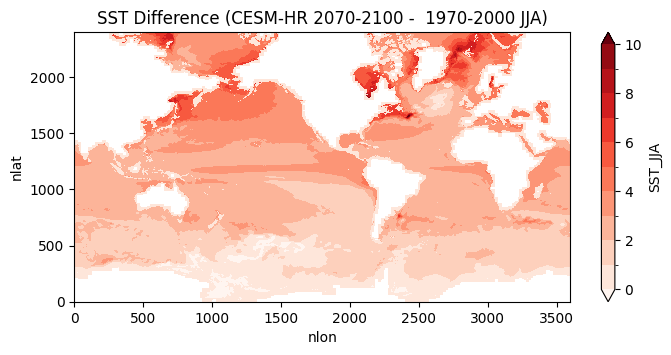

In [17]:
(sst_f-sst_h).plot(figsize=(8, 3.5),
           cmap='Reds',  
           extend='both', 
           levels=np.arange(0, 11, 1))

plt.title('SST Difference (CESM-HR 2070-2100 - 1970-2000 JJA)');

####  SST of intermediate file format LENS2 through pywinter 

In [18]:
%%time
import pywinter.winter as pyw
year_tc = ['1993',     '1994',      '2018',       '2019',      '1984',      '2005',      '2008',      '2012']
year_c = ['1978-2008', '1979-2009', '2003-2033', '2004-2034', '1969-1999', '1990-2020', '1993-2023', '1997-2027']
year_f = ['2070-2100', '2070-2100', '2070-2100', '2070-2100', '2070-2100', '2070-2100', '2070-2100', '2070-2100']
 
n_tc = len(year_tc)

for nt in range(n_tc):
    dir_o = '/glade/campaign/mmm/c3we/mingge/MPAS-PGW/' + year_tc[nt] + '_PGW/'
    
    flnm_f = dir_o + 'FUTURE:'  + year_tc[nt] + '-06-01_00'
    flnm_c = dir_o + 'CURRENT:' + year_tc[nt] + '-06-01_00'

    # future senario
    dir_f = '/glade/campaign/mmm/c3we/mingge/PGW_F/OUTPUT/'
    
    # historical period
    dir_c = '/glade/campaign/mmm/c3we/mingge/PGW_C/OUTPUT/'

    f_f = pyw.rinter(flnm_f)
    f_c = pyw.rinter(flnm_c)

    # differences
    d_skintemp = f_f['SKINTEMP'].val - f_c['SKINTEMP'].val
     

CPU times: user 218 ms, sys: 60.6 ms, total: 279 ms
Wall time: 2.41 s


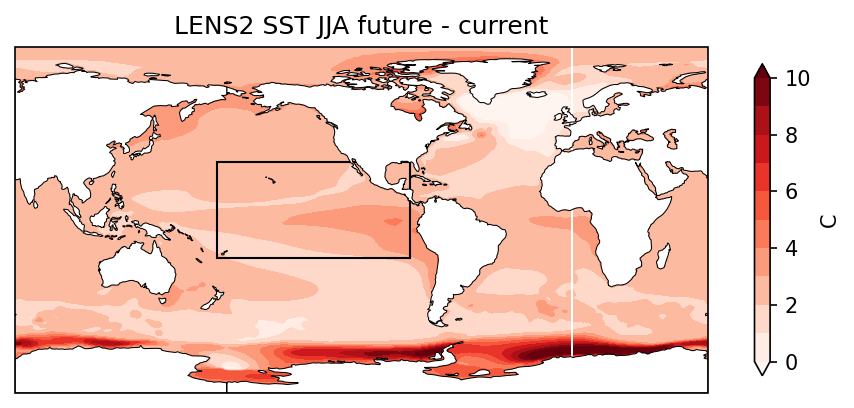

In [20]:
# creat LENS2 mesh grid (192, 288)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
n_lat_lens2 = 192
n_lon_lens2 = 288
lat_lens2 = np.linspace(-90, 90, n_lat_lens2)
lon_lens2 = np.linspace(0, 358.75, n_lon_lens2)
lon_grid_lens2, lat_grid_lens2 = np.meshgrid(lon_lens2, lat_lens2)
lon_grid_lens2_flatten = lon_grid_lens2.flatten()
lat_grid_lens2_flatten = lat_grid_lens2.flatten()

# Create the DataArray
da = xr.DataArray(
    d_skintemp,
    dims=["latitude", "longitude"],
    coords={"latitude": lat_lens2, "longitude": lon_lens2},
    name="SST"  # Optional: name of the variable
)

fig = plt.figure(dpi=150, figsize=(8,3))

# add the first subplot
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=250.0))

pc = ax.contourf(lon_lens2, lat_lens2, da,
                   transform=ccrs.PlateCarree(), cmap='Reds', extend='both', levels=np.arange(0, 11, 1))

ax.set_global() 

# draw box of Niño 3.4 (5N-5S, 170W-120W): PPM (20°S-30°N, 175°E-85°W) 
ax.add_patch(mpatches.Rectangle(xy=[175, -20], width=100, height=50,
                                facecolor='None', edgecolor='k', lw = 1,
                                transform=ccrs.PlateCarree()))
land = ax.add_feature(
    cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                        linewidth=0.5,
                                        edgecolor='black',
                                        facecolor='white'))

shf_cbar = plt.colorbar(pc, shrink=0.9, ax=ax);
shf_cbar.set_label('C')

ax.set_title('LENS2 SST JJA future - current');